In [26]:
import pandas as pd
import numpy as np

In [27]:
df = pd.read_excel('Taylor_Swift_Spotify_Data.xlsx')

In [28]:
# clean song names
clean_songs = []
for song in df['Song Name']:
    song = str(song)
    song = song.replace("‚Äô", "\'")  
    song = song.replace("‚Äò", "\'")
    clean_songs.append(song)

df['Song Name'] = clean_songs


In [29]:
df["Time Signature"].value_counts()

Time Signature
4    141
5      3
3      2
1      1
Name: count, dtype: int64

The first thing we are going to do is use just the basic KMeans clustering algorithm. KMeans only works on numerical data, so it may not be as effective as other algorithms such as KPrototypes which allow us to combine categorical and numeric data.

In [30]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [31]:
X = df.iloc[:, 3:] # take only the numeric columns
X.head()

,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Time Signature
0,0.580,0.491,0,-6.462,1,0.0251,0.575,0.0,0.1210,0.425,76.009,232107,4
1,0.658,0.877,7,-2.098,1,0.0323,0.173,0.0,0.0962,0.821,105.586,173067,4
2,0.621,0.417,10,-6.941,1,0.0231,0.288,0.0,0.1190,0.289,99.953,203040,4
3,0.576,0.777,9,-2.881,1,0.0324,0.051,0.0,0.3200,0.428,115.028,199200,4
4,0.418,0.482,5,-5.769,1,0.0266,0.217,0.0,0.1230,0.261,175.558,239013,4


In [32]:
# Scaling the data to have the same magnitue
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)


In [33]:
kmeans = KMeans(n_clusters=10, init='k-means++')
kmeans.fit(data_scaled)


/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [34]:
label = kmeans.fit_predict(X)

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [35]:
# Add the clusters back to the original dataframe
df["Cluster"] = label

Note that in order to visualize results, we need to use PCA to scale the data down to two dimensions

In [36]:
# Lets do this again, but this time using PCA
from sklearn.decomposition import PCA
pca = PCA(2)

In [37]:
transform_X = pca.fit_transform(data_scaled)
transform_X.shape

(147, 2)

In [38]:
kmeans = KMeans(n_clusters=10)
label = kmeans.fit_predict(transform_X)

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


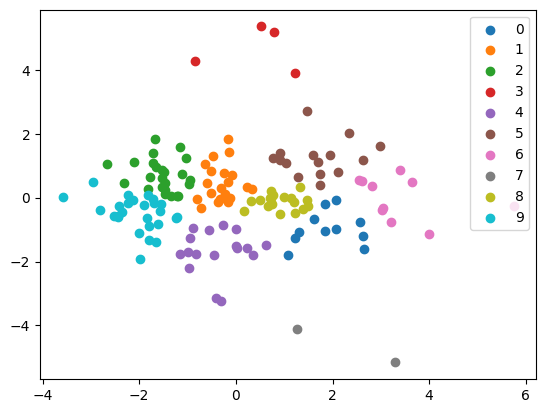

In [39]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(transform_X[label == i , 0] , transform_X[label == i , 1] , label = i)
plt.legend()
plt.show()

In [40]:
# Add points back to original dataframe
pca_X = pd.DataFrame(transform_X)


In [41]:
df["Cluster"] = label
df["PCA_X"] = pca_X.iloc[:, 0]
df["PCA_Y"] = pca_X.iloc[:, 1]

Now that we have all the data in the original dataframe, we can color by cluster and color by album

<Axes: xlabel='PCA_X', ylabel='PCA_Y'>

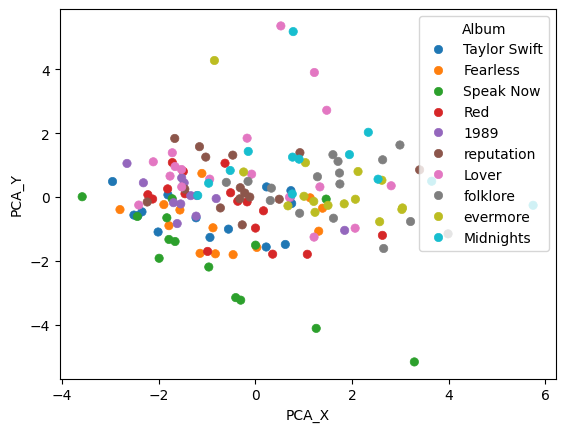

In [42]:
import seaborn as sns
sns.scatterplot(x='PCA_X', y='PCA_Y', data=df, hue='Album', ec=None)

<Axes: xlabel='PCA_X', ylabel='PCA_Y'>

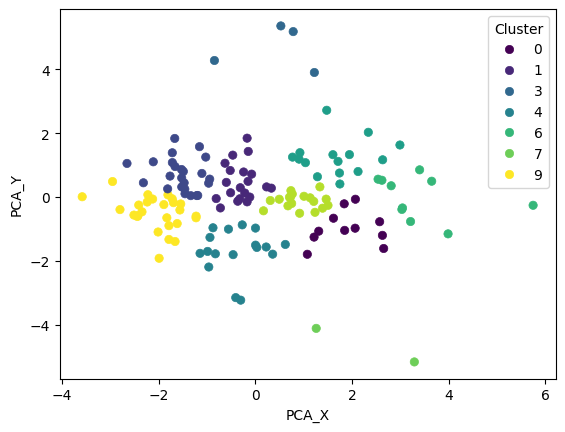

In [43]:
sns.scatterplot(x='PCA_X', y='PCA_Y', data=df, hue='Cluster', ec = None, palette='viridis')

In [44]:
from sklearn.metrics.pairwise import euclidean_distances
song_name = "august"
temp_df = df[df["Song Name"] == song_name]
print(temp_df)
song_array = np.array(temp_df[['PCA_X', 'PCA_Y']])


     Playlist ID     Album Song Name  Danceability  Energy  Key  Loudness   
110          111  folklore    august         0.532   0.623    5    -9.208  \

     Mode  Speechiness  Acousticness  Instrumentalness  Liveness  Valence   
110     1       0.0331         0.538          0.000073    0.0925    0.403  \

      Tempo  Duration_ms  Time Signature  Cluster     PCA_X     PCA_Y  
110  89.937       261923               4        8  0.914859 -0.507118  


In [45]:
# Create empty lists for songs and distances
song_names = []
song_distances= []

In [46]:
for i in range(len(df)):
    temp_array = np.array(df[df["Song Name"] == df.iloc[i]['Song Name']][['PCA_X', 'PCA_Y']])
    song_names.append(df.iloc[i]['Song Name'])
    song_distances.append(euclidean_distances(song_array.reshape(1, -1), temp_array.reshape(1, -1)))


In [47]:
d = {'Song_Names': song_names, 'Distances': song_distances} # Make dictionary
comparison_df = pd.DataFrame(d)
comparison_df.sort_values('Distances')

,Song_Names,Distances
110,august,[[0.0]]
129,cowboy like me,[[0.31962086486520375]]
130,long story short,[[0.3352723193299434]]
0,Tim McGraw,[[0.3480049123789728]]
122,'tis the damn season,[[0.47261758885880306]]
...,...,...
143,Labyrinth,[[4.837388177435463]]
132,closure,[[5.097672356173558]]
39,Last Kiss,[[5.224700956561778]]
141,Vigilante Shit,[[5.689605462647497]]
